In [ ]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://apache.website-solution.net/spark/spark-3.1.2/spark-3.1.2-bin-hadoop3.2.tgz
!tar xf spark-3.1.2-bin-hadoop3.2.tgz
!pip install -q findspark

import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.1.2-bin-hadoop3.2"

import findspark
findspark.init()
from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[*]").getOrCreate()

from pyspark import accumulators, since
from pyspark.accumulators import Accumulator
from pyspark.broadcast import Broadcast, BroadcastPickleRegistry
from pyspark.conf import SparkConf
from pyspark.files import SparkFiles
from pyspark.java_gateway import launch_gateway, local_connect_and_auth
from pyspark.serializers import PickleSerializer, BatchedSerializer, UTF8Deserializer, \
    PairDeserializer, AutoBatchedSerializer, NoOpSerializer, ChunkedStream
from pyspark.storagelevel import StorageLevel
from pyspark.resource.information import ResourceInformation
from pyspark.rdd import RDD, _load_from_socket
from pyspark.taskcontext import TaskContext
from pyspark.traceback_utils import CallSite, first_spark_call
from pyspark.status import StatusTracker
from pyspark.profiler import ProfilerCollector, BasicProfiler

from operator import add


sc = spark.sparkContext

[[  1.    1.2   0.8   3.7   3.9   3.6  10.   10.1  10.2 100. ]
 [  1.1   0.8   1.    4.    3.9   4.1  10.   10.1  10.2 100. ]]
False
None
[1, 1, 1, 2, 2, 2, 3, 3, 3, None]
[[  0.           0.2236068    0.36055513   3.96232255]
 [  0.           0.36055513   0.4472136    4.0607881 ]
 [  0.           0.2236068    0.4472136    4.17252921]
 [  0.           0.14142136   0.2236068    3.96232255]
 [  0.           0.2236068    0.36055513   4.03112887]
 [  0.           0.14142136   0.36055513   3.96988665]
 [  0.           0.14142136   0.28284271   8.62670273]
 [  0.           0.14142136   0.14142136   8.76812409]
 [  0.           0.14142136   0.28284271   8.90954544]
 [  0.         126.9963779  127.13779926 127.27922061]]
***************
[  0.14142136   0.14142136   0.14142136   0.14142136   0.14142136
   0.2236068    0.2236068    0.2236068    0.36055513 126.9963779 ]
***************


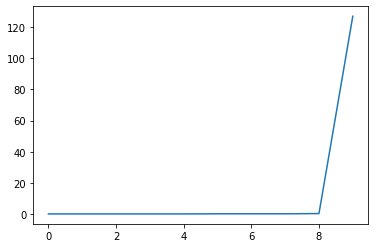

In [ ]:
# -*- coding: utf-8 -*-
"""DBScan20211111.ipynb

Automatically generated by Colaboratory.

Original file is located at
    https://colab.research.google.com/drive/1QFurx74DESUd0jzyqMUzcAdT_XfQcz0B
"""

# -*- coding: utf-8 -*-

# A Density-Based Algorithm for Discovering Clusters in Large Spatial Databases with Noise
# Martin Ester, Hans-Peter Kriegel, Jörg Sander, Xiaowei Xu
# dbscan: density based spatial clustering of applications with noise

import numpy as np
import math
from sklearn.neighbors import NearestNeighbors
from matplotlib import pyplot as plt


class DBScan:

    def __init__(self):
        self.UNCLASSIFIED = False
        self.NOISE = None

    def _dist(self, p,q):
	    return math.sqrt(np.power(p-q,2).sum())

    def _eps_neighborhood(self, p,q,eps):
	    return self._dist(p,q) < eps

    def _region_query(self, m, point_id, eps):
        n_points = m.shape[1]

        seeds = []
        for i in range(0, n_points):
            if self._eps_neighborhood(m[:,point_id], m[:,i], eps):
                seeds.append(i)
        return seeds

    def _expand_cluster(self, m, classifications, point_id, cluster_id, eps, min_points):
        seeds = self._region_query(m, point_id, eps)
        if len(seeds) < min_points:
            classifications[point_id] = self.NOISE
            return False
        else:
            classifications[point_id] = cluster_id
            for seed_id in seeds:
                classifications[seed_id] = cluster_id
            
            while len(seeds) > 0:
                current_point = seeds[0]
                results = self._region_query(m, current_point, eps)
                if len(results) >= min_points:
                    for i in range(0, len(results)):
                        result_point = results[i]
                        if classifications[result_point] == self.UNCLASSIFIED or \
                        classifications[result_point] == self.NOISE:
                            if classifications[result_point] == self.UNCLASSIFIED:
                                seeds.append(result_point)
                            classifications[result_point] = cluster_id
                seeds = seeds[1:]
            return True
        
    def dbscan(self, m, eps, min_points):
        
        cluster_id = 1

        n_points = m.shape[1]


        print(self.UNCLASSIFIED)
        print(self.NOISE)

        classifications = [self.UNCLASSIFIED] * n_points
        for point_id in range(0, n_points):
            point = m[:,point_id]
            if classifications[point_id] == self.UNCLASSIFIED:
                if self._expand_cluster(m, classifications, point_id, cluster_id, eps, min_points):
                    cluster_id = cluster_id + 1
        return classifications


    def elbow(self, X, K):

        nbrs = NearestNeighbors(n_neighbors=4).fit(X)
        distances, indices = nbrs.kneighbors(X)
        print(distances)

        distances = np.sort(distances, axis=0)
        distances = distances[:,1]

        print("***************")
        print(distances)

        plt.plot(distances)
        print("***************")



def test_dbscan():

    # Shirley data
    m1 = np.matrix('1 1.2 0.8 3.7 3.9 3.6 10 10.1 10.2 100; 1.1 0.8 1 4 3.9 4.1 10 10.1 10.2 100')
    print(m1)


    eps = 2
    min_points = 2

    DB = DBScan()

    print(DB.dbscan(m1, eps, min_points))
    
    #print(DB.dbscan(1, 2, 2))

    # Shirley data
    X = np.array([[1, 1.1], [1.2, 0.8],[0.8, 1], [3.7, 4], [3.9, 3.9], [3.6, 4.1], [10, 10], [10.1, 10.1],[10.2, 10.2],[100,100]])
    K = 4
    DB.elbow(X, K)


test_dbscan()

In [ ]:
import pandas
import pyspark as ps
import sklearn.cluster as skc
import numpy as np
import datetime
# from dbscan import DBScan

if __name__ == '__main__':
    pd = pandas.read_csv('./3000.txt', sep=" ", header=None)
    m = pd.T
    # output.to_csv(r'SmallDataSet.txt', header=None, index=None)

    # m = pandas.read_csv('SmallDataSet.txt', sep=",", header=None)
    
    rd = datetime.datetime.now()
    print("Run DBScan - ", rd)
    
    m1 = np.matrix(m)
    # print (m1)
    
    eps = 1000
    min_points = 10
    DB = DBScan()

    classifications = DB.dbscan(m1, eps, min_points)
    print(classifications)
    
    # X = np.array(pd)
    # K = 4
    # DB.elbow(X,K)
    
    ed = datetime.datetime.now()
    print("End DBScan - ", ed)
    difference = ed - rd
    print("Total time spend - ", difference.seconds, " seconds")

    classifications
    a_set = set(classifications)
    number_of_unique_values = len(a_set)
    print(number_of_unique_values)

Run DBScan -  2021-11-30 03:40:40.796972
False
None
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, None, 1, 1, 1, 1, 1, 1, 1, None, 1, 1, 1, 1, 1, 1, 1, 1, None, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, None, 1, None, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, None, 1, None, 1, 1, 1, 1, 1, 1, 1, None, 1, 1, 1, None, None, 1, 1, 1, 1, None, 1, 1, 1, 1, 1, 1, 1, 1, None, 1, 1, 1, 1, None, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, None, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, None, 2, None, 2, 2, 2, 2, 2, 2, 2, 2, 2, None, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, None, 2, 2, 2, 2, 2, 2, 2, 2, None, 2, None, None, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, None, 2, 2, 2, 2, 2, 2, 2, 2, 2, None, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, None, 2, 2, 2, 2, 2, 2, 2, 2, 2,